# LR Analysis

This notebook analyze the LR properties of a system starting from the coupling matrix, transition quantities and the energies of the virtual orbitals

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import DoS as D
from futile import Yaml
from futile.Utils import write
#import matplotlib
#matplotlib.use('GTKAgg') 
import matplotlib.pyplot as plt
import numpy as np
import LRTDDFT as LR
HaeV=27.21138386

Autosave disabled


In [2]:
def build_syst_dict(systPath,norb):
    syst = {}
    outp = systPath+'linear-response/log'
    %cd $outp
    logs = !ls log-Rmult_*
    for l in logs:
        data = lf.Logfile(l)
        rmult = data.log['dft']['rmult'][0]
        nvirt = len(data.evals[0][0]) - norb
        syst[rmult] = {'nvirt':nvirt}
    %cd ../../../../
    return syst
    
def get_tddft_quantities(syst,sysPath):
    from futile.Utils import write
    outp = sysPath+'linear-response/log'
    %cd $outp
    for rVal in syst:
        dpath = 'data-'+'Rmult_'+str(rVal)+'/transition_quantities.txt'
        trans = np.loadtxt(dpath)
        syst[rVal]['T']=trans
        cpath = 'data-'+'Rmult_'+str(rVal)+'/coupling_matrix.txt'
        Cmat = np.loadtxt(cpath)
        syst[rVal]['C']=Cmat
        write('Casida Matrix is symmetric',np.allclose(Cmat,Cmat.T,atol=1.e-12))
        syst[rVal]['logfile'] = lf.Logfile('log-Rmult_'+str(rVal)+'_numVirt_'+str(syst[rVal]['nvirt'])+'.yaml')
    %cd ../../../../

## Analysis of $CO$

In [3]:
norbCO = 5
pathCO = 'CO/free-bc/'
CO = build_syst_dict(pathCO, norbCO)
naSmall = [16,64,96,160]
CO

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/CO/free-bc/linear-response/log
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


{7.0: {'nvirt': 280}, 9.0: {'nvirt': 280}, 10.0: {'nvirt': 280}}

In [4]:
reload(LR)
get_tddft_quantities(CO,pathCO)

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/CO/free-bc/linear-response/log
Casida Matrix is symmetric True
Casida Matrix is symmetric True
Casida Matrix is symmetric True
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


Chose the value of nalpha that give the same maximum energy in all the box

In [5]:
nalphaEmax = {}
rVals = CO.keys()
rVals.sort()
eMax = CO[rVals[-1]]['logfile'].evals[0][0][-1]
nalphaEmax[rVals[-1]] = len(CO[rVals[-1]]['logfile'].evals[0][0])-norbCO
print 'max sampled energy = ', HaeV*eMax
for r in rVals[0:len(rVals)-1][::-1]:
    na = 0
    em = 0
    while(em<eMax):
        na+=1
        em= CO[r]['logfile'].evals[0][0][norbCO+na]
    nalphaEmax[r] = na
nalphaEmax

max sampled energy =  14.7769179033


{7.0: 98, 9.0: 185, 10.0: 280}

In [6]:
# Activate this if the result for the highest number of nalpha is needed
#nalphaEmax = {7.0:280,9.0:280,10.0:280}
nalphaEmax

{7.0: 98, 9.0: 185, 10.0: 280}

In [7]:
#reload(LR)
#LR.build_eigenp_dict(5,CO[7.0]['nvirt'],CO[7.0]['C'],CO[7.0]['T'],16)

In [8]:
reload(LR)
LR.diagonalize_CM(norbCO,CO,naSmall,nalphaEmax)
LR.collect_LR(CO)

Solve for rVal =  9.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 160
Eigensystem solved for 185
Solve for rVal =  10.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 160
Eigensystem solved for 280
Solve for rVal =  7.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 98


In [9]:
CO[7.0]['eigenproblems'][16].keys()

['eigenvectors',
 'alpha_xyz',
 'oscillator_strengths',
 'Cmat',
 'eigenvalues',
 'transitions',
 'oscillator_strength_avg']

### Statical polarizability

Plot the convergence of the statical polarizability in the various box

In [10]:
CO_alpha_ref = {'alphaX':13.235,'alphaY':13.235,'alphaZ':18.728}

In [11]:
reload(LR)
alpha_CO = LR.collect_Alpha(CO,norbCO)

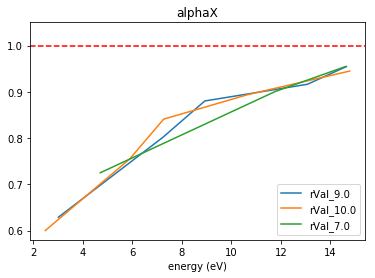

In [12]:
%matplotlib inline
component = 'alphaX'
for rVal in alpha_CO:
    val = np.array(alpha_CO[rVal][component])/CO_alpha_ref[component]
    plt.plot(alpha_CO[rVal]['naEnergy'],val,label='rVal_'+str(rVal))
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.title(component)
plt.ylim(ymax=1.05)
plt.show()

### Dynamical polarizability

In [13]:
reload(LR)
CO_spectrum = LR.collect_spectrum(CO)

Compute for rVal =  9.0  with nalpha =  185
numpoint =  316  omegaMax (eV) =  43.0272129952
Compute for rVal =  10.0  with nalpha =  280
numpoint =  311  omegaMax (eV) =  42.431982253
Compute for rVal =  7.0  with nalpha =  98
numpoint =  316  omegaMax (eV) =  43.0968827189


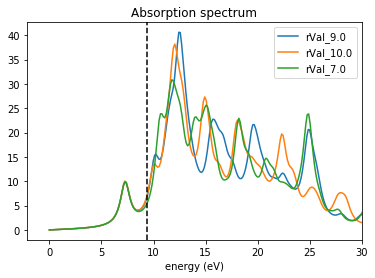

In [14]:
%matplotlib inline
syst = CO_spectrum
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=30)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Absorption spectrum')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[7.0]['logfile'],norbCO,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

### Excitations

We add the threshold key to the dictionary (for the first numExc excitations)

In [58]:
reload(LR)
numExc = 900
LR.collect_excitation_thr(CO,norbCO,numExc,1e-4)

In [59]:
for rVal in CO:
    nalpha = CO[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]
    maxEng = HaeV*np.sqrt(CO[rVal]['eigenproblems'][nvirt]['eigenvalues'][numExc-1]) 
    print 'maxEng for rval_', rVal, ' = ', maxEng

maxEng for rval_ 9.0  =  21.8861126193
maxEng for rval_ 10.0  =  19.8924830183
maxEng for rval_ 7.0  =  39.3968120121


We plot the excitations landscape in the different box

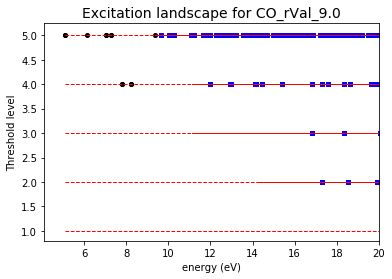

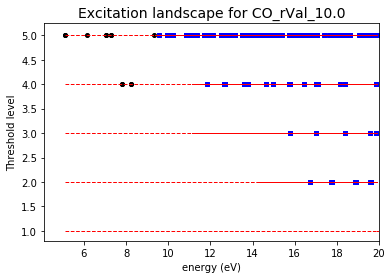

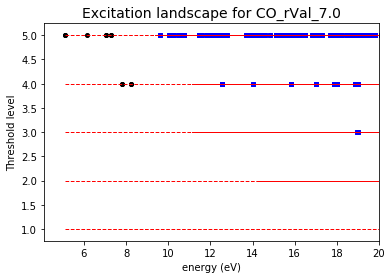

In [60]:
for rVal in CO:
    nalpha = CO[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]
    syst = CO[rVal]['eigenproblems'][nvirt]
    pEng = LR.get_p_energy(CO[rVal]['logfile'],norbCO)

    Emin = HaeV*np.sqrt(syst['eigenvalues'][0])
    Emax = HaeV*np.sqrt(syst['eigenvalues'][numExc-1])

    for ind,p in enumerate(pEng):
        plt.plot((Emin,HaeV*abs(p)),(ind+1,ind+1),'--',c='red',linewidth=1)
        plt.plot((HaeV*abs(p),Emax),(ind+1,ind+1),'-',c='red',linewidth=1)
    
    for exc in range(numExc):
        eng = HaeV*np.sqrt(syst['eigenvalues'][exc])
        thind = syst['thresholds'][exc][0]
        th = HaeV*syst['thresholds'][exc][1]
        if eng < th : 
            plt.scatter(eng,thind,s=16,marker='o',c='black')
        else :
            plt.scatter(eng,thind,s=14,marker='s',c='blue')
    plt.title('Excitation landscape for CO_rVal_'+str(rVal),size=14) 
    plt.xlabel('energy (eV)')
    plt.ylabel('Threshold level')
    plt.xlim(xmin=Emin-1,xmax=20)#Emax)
    plt.show()

We plot the dos (of a given channel) comparing the results of different box

In [61]:
reload(LR)
channels = LR.collect_channels(CO,norbCO,numExc)

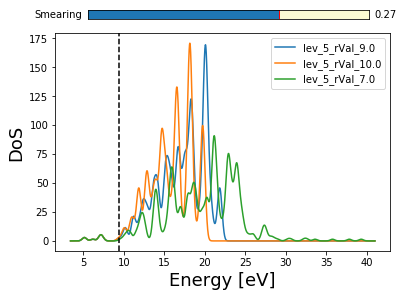

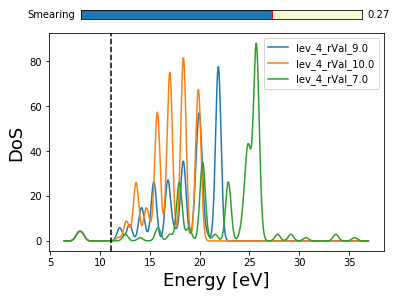

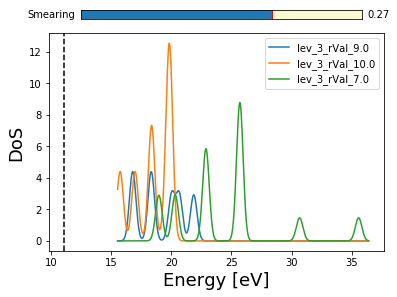

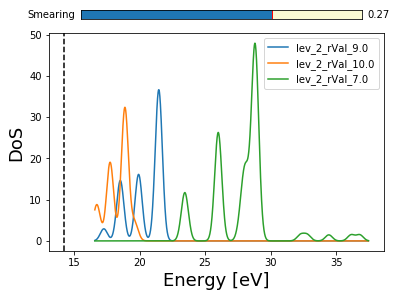

In [62]:
%matplotlib inline
levels = [5,4,3,2]
for l in levels:
    fe = HaeV*abs(LR.get_p_energy(CO[7.0]['logfile'],norbCO)[l-1])
    dos=D.DoS(fermi_level=fe)
    for rVal in channels:
        dos.append(energies=np.array([channels[rVal][l-1]]),label='lev_'+str(l)+'_rVal_'+str(rVal))
    dos.plot(sigma=0.01*HaeV)

These plots evidence the box independence of the excitations below threshold

As a final analysis we repeat the calculation of dynamical polarizability separing the contributions due to excitations above and below threshold 

In [63]:
reload(LR)
CO_spectrum_bt,CO_spectrum_at = LR.collect_spectrum_bt_at(CO)

numpoint =  160  omegaMax (eV) =  21.8861126193
numpoint =  160  omegaMax (eV) =  21.8861126193
numpoint =  146  omegaMax (eV) =  19.8924830183
numpoint =  146  omegaMax (eV) =  19.8924830183
numpoint =  289  omegaMax (eV) =  39.3968120121
numpoint =  289  omegaMax (eV) =  39.3968120121


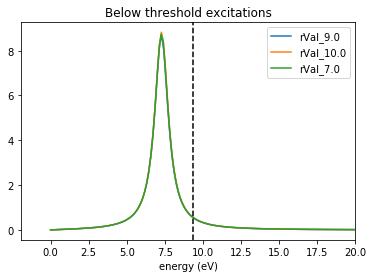

In [64]:
%matplotlib inline
syst = CO_spectrum_bt
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=20)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Below threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[7.0]['logfile'],norbCO,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

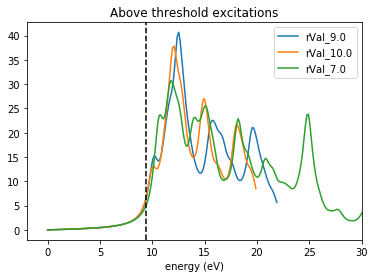

In [65]:
%matplotlib inline
syst = CO_spectrum_at
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=30)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Above threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[7.0]['logfile'],norbCO,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

Detailed analysis of the excitations channels

In [23]:
print HaeV*LR.get_p_energy(CO[7.0]['logfile'],norbCO)
print HaeV*LR.get_p_energy(CO[9.0]['logfile'],norbCO)
print HaeV*LR.get_p_energy(CO[10.0]['logfile'],norbCO)

[-27.65494303 -14.24083585 -11.117007   -11.11700672  -9.36639558]
[-27.65506619 -14.24095328 -11.11712157 -11.11712129  -9.36652264]
[-27.65506692 -14.24095398 -11.11712224 -11.11712197  -9.36652341]


In [24]:
ch = 4
print 'th energy', HaeV*abs(LR.get_p_energy(CO[7.0]['logfile'],norbCO)[ch])
for a,b,c in zip(channels[7.0][ch][0:10],channels[9.0][ch][0:10],channels[10.0][ch][0:10]):
    print a,b,c

th energy 9.366395583
5.11580140482 5.11430463224 5.11657407485
5.11588758699 5.114307195 5.11657950037
7.27704543333 7.27233581702 7.27921919941
7.27731357227 7.27234327841 7.2792239954
9.61180457682 9.35966916275 9.31049918363
10.0402253608 9.65655840525 9.5752343279
10.2069611912 10.0366839111 9.93254348341
10.2070611026 10.0745135779 9.9567333347
10.4409858008 10.1421241835 10.0441374946
10.5509213592 10.1421325416 10.0441378058


In [25]:
ch = 3
print 'th energy', HaeV*abs(LR.get_p_energy(CO[7.0]['logfile'],norbCO)[ch])
for a,b,c in zip(channels[7.0][ch][0:10],channels[9.0][ch][0:10],channels[10.0][ch][0:10]):
    print a,b,c

th energy 11.117006716
6.14186573539 6.13003986462 6.13803862609
7.04488797339 7.04275653493 7.04515699314
7.04752675936 7.04543361594 7.04782134014
7.78521043309 7.78493412963 7.78492559802
7.78521043319 7.78493412978 7.78492559818
8.21519891142 8.21419308171 8.21477101366
8.21748495313 8.21646221038 8.21704197982
11.4683528944 11.189047284 11.131491973
11.5533951434 11.2432220967 11.1773744211
12.4210769501 11.8211114499 11.7084971104


In [26]:
ch = 2
print 'th energy', HaeV*abs(LR.get_p_energy(CO[7.0]['logfile'],norbCO)[ch])
for a,b,c in zip(channels[7.0][ch][0:10],channels[9.0][ch][0:10],channels[10.0][ch][0:10]):
    print a,b,c

th energy 11.1170070015
11.4683694256 11.1890483563 11.1315009117
11.553411791 11.2432235839 11.1773761067
15.5213972738 11.8211109137 11.7084941072
15.6219408064 11.8785314273 11.7546921934
15.6398574928 13.5461146186 12.9931767518
15.7264922288 14.2414189751 13.0622190336
15.7600693335 15.394572913 13.4882874695
16.2845332367 16.8049412837 13.6033009658
16.5004055978 16.8050002734 13.6097539181
17.7478397462 16.8058062404 13.6119094019


In [189]:
rVal= 9.0
syst = CO[rVal]['eigenproblems']
nalpha = syst.keys()
nalpha.sort()
nvirt = nalpha[-1]

for exc in range(50):

    pProj = LR.identify_contributions(norbCO,nvirt,exc,syst[nvirt]['eigenvectors'])
    out = pProj[0:norbCO] + pProj[norbCO:2*norbCO]
    #for ind,o in enumerate(out):
    #    if o<1e-5: 
    #        out[ind] = 0.0
    #som = 0
    #for o in out: som+=o
    #print out, som, HaeV*np.sqrt(syst[nvirt]['eigenvalues'][exc]),syst[nvirt]['oscillator_strength_avg'][exc] 
    print exc, out, HaeV*np.sqrt(syst[nvirt]['eigenvalues'][exc])#,syst[nvirt]['oscillator_strength_avg'][exc] 

0 [  5.18952995e-05   4.15761386e-03   2.26370270e-04   5.39382202e-05
   9.95510182e-01] 5.11430463224
1 [  5.18945469e-05   4.15756510e-03   5.39387589e-05   2.26383383e-04
   9.95510218e-01] 5.114307195
2 [  3.86169822e-04   9.75984080e-04   4.98740103e-01   4.98737794e-01
   1.15994891e-03] 6.13003986462
3 [  2.23373227e-06   1.08119599e-04   4.99827942e-01   4.99828736e-01
   2.32969301e-04] 7.04275653493
4 [  2.24190981e-06   1.08163228e-04   4.99827074e-01   4.99829334e-01
   2.33186902e-04] 7.04543361594
5 [  7.69051258e-04   2.68315128e-02   2.02292807e-03   4.69630867e-04
   9.69906877e-01] 7.27233581702
6 [  7.69060633e-04   2.68316968e-02   4.69622531e-04   2.02297532e-03
   9.69906645e-01] 7.27234327841
7 [  7.76916687e-15   4.76908500e-12   5.00000395e-01   4.99999605e-01
   2.69190445e-12] 7.78493412963
8 [  9.70660109e-15   1.58316985e-11   4.99999312e-01   5.00000688e-01
   4.90609827e-11] 7.78493412978
9 [  3.79941843e-06   4.86659692e-05   4.99942607e-01   4.99941230

Reduction of p components

In [179]:
th_eng = HaeV*abs(LR.get_p_energy(CO[7.0]['logfile'],norbCO))
norb_cut = [5,4,2,1]
print th_eng
print norb_cut
for rVal in CO:
    write('Solve for rVal = ', rVal)
    nalpha = CO[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]
    syst = CO[rVal]['eigenproblems'][nvirt]
    syst['excitations'] = {}
    for n in norb_cut:
        C_ext,dipoles_ext = LR.extract_subset([n],[nvirt],syst['Cmat'],syst['transitions'],[nvirt])
        write('Casida Matrix is symmetric',np.allclose(C_ext,C_ext.T,atol=1.e-12))
        E2,C_E2 = np.linalg.eigh(C_ext)
        C_E2 = C_E2.T
        newdipole=[]
        for line in dipoles_ext:
            newdipole.append(line[0]*np.array(line[1:]))
        newdipole=np.array(newdipole)
        write('Eigensystem solved for norb_cut = ',n)
        syst['excitations'][n] =  {'Cmat':C_ext,'eigenvalues':E2,'eigenvectors':C_E2,'transitions':newdipole}

[ 27.65494303  14.24083585  11.117007    11.11700672   9.36639558]
[5, 4, 2, 1]
Solve for rVal =  9.0
Casida Matrix is symmetric True
Eigensystem solved for norb_cut =  5
Casida Matrix is symmetric True
Eigensystem solved for norb_cut =  4
Casida Matrix is symmetric True
Eigensystem solved for norb_cut =  2
Casida Matrix is symmetric True
Eigensystem solved for norb_cut =  1
Solve for rVal =  10.0
Casida Matrix is symmetric True
Eigensystem solved for norb_cut =  5
Casida Matrix is symmetric True
Eigensystem solved for norb_cut =  4
Casida Matrix is symmetric True
Eigensystem solved for norb_cut =  2
Casida Matrix is symmetric True
Eigensystem solved for norb_cut =  1
Solve for rVal =  7.0
Casida Matrix is symmetric True
Eigensystem solved for norb_cut =  5
Casida Matrix is symmetric True
Eigensystem solved for norb_cut =  4
Casida Matrix is symmetric True
Eigensystem solved for norb_cut =  2
Casida Matrix is symmetric True
Eigensystem solved for norb_cut =  1


In [30]:
rVal = 7.0
numExc = 12
nalpha = CO[rVal]['eigenproblems'].keys()
nalpha.sort()
nvirt = nalpha[-1]
print 'all exc',HaeV*np.sqrt(CO[rVal]['eigenproblems'][nvirt]['eigenvalues'][0:30])
print ''
for n in norb_cut:
    print 'np_cut = ',n,HaeV*np.sqrt(CO[rVal]['eigenproblems'][nvirt]['excitations'][n]['eigenvalues'][0:numExc])

all exc [  5.1158014    5.11588759   6.14186574   7.04488797   7.04752676
   7.27704543   7.27731357   7.78521043   7.78521043   8.21519891
   8.21748495   9.61180458  10.04022536  10.20696119  10.2070611
  10.4409858   10.55092136  10.72981728  10.7299096   10.74300571
  10.7432496   11.46835289  11.46836943  11.55339514  11.55341179
  11.77903526  11.94862164  11.95233852  12.00854303  12.01233145]

np_cut =  5 [ 5.1158014   5.11588759  6.14186574  7.04488797  7.04752676  7.27704543
  7.27731357  7.78521043  7.78521043  8.21519891  8.21748495  9.61180458]
np_cut =  4 [  6.33023247   6.33719656   6.55776814   7.26643077   7.75903408
   7.78521043   8.08921642   9.86486186  10.20995938  10.22088131
  10.50789468  10.7350401 ]
np_cut =  2 [  7.66456823   7.66701976   7.78521043  10.96559508  11.50331496
  11.50332133  11.54613877  11.54614493  12.31922289  12.31922882
  12.48948245  12.48957765]
np_cut =  1 [ 11.58570678  11.5857339   14.74732302  15.47714888  15.6809391
  15.68110006  

### Construction of a projector

In [153]:
n=4
M=np.matrix(np.random.rand(n*n).reshape(n,n))
H = M + M.T
#print 'H =', H
eigen,w = np.linalg.eigh(H) 
w = w.T # sorted as row vectors w[ind]
for ind,e in enumerate(eigen):
    isok = np.allclose(H.dot(w[ind].T),e*w[ind].T,atol=1.e-12)
    if not isok: print('Eigenvalue',ind,'is false')

In [154]:
print eigen
print w

[-1.67912121 -0.47950737  1.23838126  3.9580638 ]
[[-0.37897729  0.33038231  0.66536219 -0.55183049]
 [ 0.60824883  0.44855504 -0.34030235 -0.55948731]
 [ 0.55338745 -0.65668345  0.46767004 -0.20931773]
 [-0.42446661 -0.50834315 -0.47198749 -0.58193053]]


In [229]:
print w[0].shape
print w[0].T.shape

(1, 4)
(4, 1)


In [155]:
#Q = np.eye(n)- np.dot(w[:,0],w[:,0].T)
ind_cut = 0
Q = np.eye(n)- np.dot(w[ind_cut].T,w[ind_cut])
Q

matrix([[ 0.85637621,  0.12520739,  0.25215716, -0.20913122],
        [ 0.12520739,  0.89084753, -0.2198239 ,  0.18231503],
        [ 0.25215716, -0.2198239 ,  0.55729315,  0.36716715],
        [-0.20913122,  0.18231503,  0.36716715,  0.69548311]])

In [156]:
Hproj = np.dot(np.dot(Q,H),Q)
eigen_cut,w_cut = np.linalg.eigh(Hproj)
w_cut = w_cut.T

In [157]:
print eigen_cut
print w_cut

[ -4.79507371e-01  -6.89731163e-16   1.23838126e+00   3.95806380e+00]
[[-0.60824883 -0.44855504  0.34030235  0.55948731]
 [ 0.37897729 -0.33038231 -0.66536219  0.55183049]
 [ 0.55338745 -0.65668345  0.46767004 -0.20931773]
 [-0.42446661 -0.50834315 -0.47198749 -0.58193053]]


### Reduction of the excitations

In [43]:
rVal = 7.0
th_eng = HaeV*abs(LR.get_p_energy(CO[rVal]['logfile'],norbCO))
norb_cut = [5,4,2,1]
print th_eng
print norb_cut
nalpha = CO[rVal]['eigenproblems'].keys()
nalpha.sort()
nvirt = nalpha[-1]
print 'nvirt', nvirt
syst = CO[rVal]['eigenproblems'][nvirt]
syst['excitations'] = {}

[ 27.65494303  14.24083585  11.117007    11.11700672   9.36639558]
[5, 4, 2, 1]
nvirt 98


In [44]:
print 'all exc',HaeV*np.sqrt(CO[rVal]['eigenproblems'][nvirt]['eigenvalues'][0:30])

all exc [  5.1158014    5.11588759   6.14186574   7.04488797   7.04752676
   7.27704543   7.27731357   7.78521043   7.78521043   8.21519891
   8.21748495   9.61180458  10.04022536  10.20696119  10.2070611
  10.4409858   10.55092136  10.72981728  10.7299096   10.74300571
  10.7432496   11.46835289  11.46836943  11.55339514  11.55341179
  11.77903526  11.94862164  11.95233852  12.00854303  12.01233145]


First step: identify the excitation below th of the complete matrix and build the projector

In [45]:
ind_cut = 0
C_ext,dipoles_ext = LR.extract_subset([norb_cut[ind_cut]],[nvirt],syst['Cmat'],syst['transitions'],[nvirt])
E2,C_E2 = np.linalg.eigh(C_ext)
C_E2 = C_E2.T
newdipole=[]
for line in dipoles_ext:
    newdipole.append(line[0]*np.array(line[1:]))
newdipole=np.array(newdipole)
ind_bt = 0
while (HaeV*np.sqrt(E2[ind_bt]) < th_eng[norb_cut[ind_cut]-1]):
    ind_bt+=1
print ind_bt 
E2 = E2[0:ind_bt]
C_E2 = C_E2[0:ind_bt]
print 'excitations_bt: ',HaeV*np.sqrt(E2)
syst['excitations'][norb_cut[ind_cut]] = {'Cmat':C_ext,'eigenvalues_bt':E2,'eigenvectors_bt':C_E2,'transitions':newdipole}

11
excitations_bt:  [ 5.1158014   5.11588759  6.14186574  7.04488797  7.04752676  7.27704543
  7.27731357  7.78521043  7.78521043  8.21519891  8.21748495]


In [46]:
exc_contr_th = 1e-5
exc_contr_ind = []
for exc in range(len(syst['excitations'][norb_cut[ind_cut]]['eigenvalues_bt'])):
    pProj = LR.identify_contributions(norb_cut[ind_cut],nvirt,exc,syst['excitations'][norb_cut[ind_cut]]['eigenvectors_bt'])
    out = pProj[0:norbCO] + pProj[norbCO:2*norbCO]
    if out[norb_cut[ind_cut]-1] > exc_contr_th:
        exc_contr_ind.append(exc)
exc_contr_ind

[0, 1, 2, 3, 4, 5, 6, 9, 10]

In [47]:
Q = np.eye(len(syst['excitations'][norb_cut[ind_cut]]['Cmat']))
for exc in exc_contr_ind:
    vet = syst['excitations'][norb_cut[ind_cut]]['eigenvectors_bt'][exc]
    vet = np.reshape(vet,(len(vet),1))
    Q+=- np.dot(vet,vet.T)

In [48]:
Cproj = np.dot(np.dot(Q,syst['excitations'][norb_cut[ind_cut]]['Cmat']),Q)
E2_cut,C_cut = np.linalg.eigh(Cproj)
C_cut = C_cut.T

In [49]:
print HaeV*np.sqrt(E2_cut[0:20])

[             nan              nan              nan              nan
   1.08654770e-07   4.70009490e-07   5.19665069e-07   6.39098261e-07
   8.73816280e-07   7.78521043e+00   7.78521043e+00   9.61180458e+00
   1.00402254e+01   1.02069612e+01   1.02070611e+01   1.04409858e+01
   1.05509214e+01   1.07298173e+01   1.07299096e+01   1.07430057e+01]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


Ok. The first eigenvalues are zero and the other ones are the same...Now we remove the first channel and go ahead

In [50]:
ind_cut = 1
#C_ext,dipoles_ext = LR.extract_subset([norb_cut[ind_cut]],[nvirt],syst['Cmat'],syst['transitions'],[nvirt])
C_ext,dipoles_ext = LR.extract_subset([norb_cut[ind_cut]],[nvirt],Cproj,syst['transitions'],[nvirt])
E2,C_E2 = np.linalg.eigh(C_ext)
C_E2 = C_E2.T
newdipole=[]
for line in dipoles_ext:
    newdipole.append(line[0]*np.array(line[1:]))
newdipole=np.array(newdipole)
ind_bt = 0
while (HaeV*np.sqrt(E2[ind_bt]) < th_eng[norb_cut[ind_cut]-1]):
    ind_bt+=1
print ind_bt
E2 = E2[0:ind_bt]
C_E2 = C_E2[0:ind_bt]
print 'excitations_bt: ',HaeV*np.sqrt(E2)
syst['excitations'][norb_cut[ind_cut]] = {'Cmat':C_ext,'eigenvalues_bt':E2,'eigenvectors_bt':C_E2,'transitions':newdipole}

14
excitations_bt:  [  0.24055653   0.33655134   0.49427948   0.66579441   0.74826981
   5.50409404   7.78521043   9.84372441  10.20477728  10.2158304
  10.50298063  10.73356995  10.73430119  10.98019584]


spurious states appear....

### Excitations again

First of all we perform a plot of the dos of the excitations comparing the different box

Analysis for rVal  9.0
Analysis for rVal  10.0
Analysis for rVal  7.0


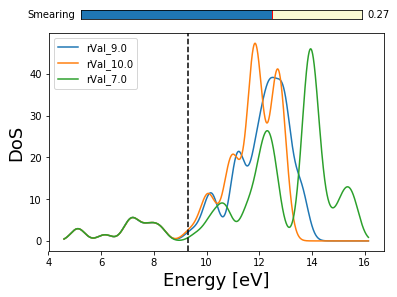

In [197]:
dos=D.DoS(fermi_level=9.3)
for rVal in CO:
    print 'Analysis for rVal ', rVal
    nalpha = CO[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]
    syst = CO[rVal]['eigenproblems'][nvirt]
    exc_eng = HaeV*np.sqrt(syst['eigenvalues'][0:100])
    dos.append(energies=np.array([exc_eng]),label='rVal_'+str(rVal))
dos.plot(sigma=0.01*HaeV)

We look for the excitations in a energy sector. If the eigenvectors has negligible component on the psi_p states above the threshold we add the excitation to the discrete set.

Analysis for rVal  9.0
energy levels [ 27.65506619  14.24095328  11.11712157  11.11712129   9.36652264]
energy range 9.36652264479 11.1171212927
energy range 11.1171215691 14.2409532843
energy range 14.2409532843 27.6550661908

Analysis for rVal  10.0
energy levels [ 27.65506692  14.24095398  11.11712224  11.11712197   9.36652341]
energy range 9.36652341389 11.1171219685
energy range 11.1171222441 14.2409539754
energy range 14.2409539754 27.6550669159

Analysis for rVal  7.0
energy levels [ 27.65494303  14.24083585  11.117007    11.11700672   9.36639558]
energy range 9.366395583 11.117006716
energy range 11.1170070015 14.240835853
energy range 14.240835853 27.6549430296

{9.0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 10.0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 7.0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}


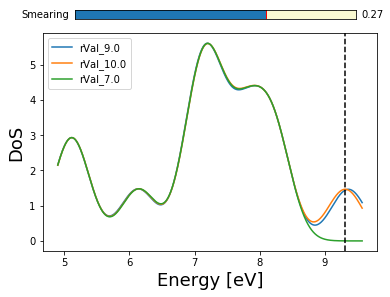

In [175]:
th_value = 1e-3
discrete_exc = {}
dos=D.DoS(fermi_level=9.3)

for rVal in CO:
    print 'Analysis for rVal ', rVal
    nalpha = CO[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]
    syst = CO[rVal]['eigenproblems'][nvirt]
    exc_eng = HaeV*np.sqrt(syst['eigenvalues'])
    exc_vect = syst['eigenvectors']
    discrete_exc[rVal] = []
    th_eng = HaeV*abs(LR.get_p_energy(CO[rVal]['logfile'],norbCO))
    print 'energy levels', th_eng
    
    #First channel. Add to the discrete_exc list all the excitations below the first th
    ind = 0
    while (exc_eng[ind]<th_eng[4]):
        discrete_exc[rVal].append(ind)
        ind+=1
    
    #Second channel. Consider excitations with energy between the first and the second th and add to 
    #discrete_exc if the projection of the eigenvector on the last psi_p is below th_value
    ind = 0
    print 'energy range', th_eng[4], th_eng[3]  
    while (exc_eng[ind]<th_eng[3]):
        if (exc_eng[ind]>=th_eng[4]):
            pProj = LR.identify_contributions(norbCO,nvirt,ind,exc_vect)
            pProj = pProj[0:norbCO] + pProj[norbCO:2*norbCO]
            if pProj[4] < th_value : 
                print 'second channel add ind ', ind
                discrete_exc[rVal].append(ind)
        ind+=1
    
    #Third channel. Including the degeneracy
    ind = 0
    print 'energy range', th_eng[2], th_eng[1]  
    while (exc_eng[ind]<th_eng[1]):
        if (exc_eng[ind]>=th_eng[2]): # or 3
            pProj = LR.identify_contributions(norbCO,nvirt,ind,exc_vect)
            pProj = pProj[0:norbCO] + pProj[norbCO:2*norbCO]
            if pProj[2] < th_value and pProj[3] < th_value and pProj[4] < th_value : 
                print 'third channel add ind ', ind
                discrete_exc[rVal].append(ind)
        ind+=1
    
    #Fourth channel
    ind = 0
    print 'energy range', th_eng[1], th_eng[0]  
    while (exc_eng[ind]<th_eng[0]):
        if (exc_eng[ind]>=th_eng[1]):
            pProj = LR.identify_contributions(norbCO,nvirt,ind,exc_vect)
            pProj = pProj[0:norbCO] + pProj[norbCO:2*norbCO]
            if pProj[1] < th_value and pProj[2] < th_value and pProj[3] < th_value and pProj[4] < th_value : 
                print 'fourth add ind ', ind
                discrete_exc[rVal].append(ind)
        ind+=1
        
    dos.append(energies=np.array([exc_eng[discrete_exc[rVal]]]),label='rVal_'+str(rVal))
    print ''

print discrete_exc
dos.plot(sigma=0.01*HaeV)

In [213]:
reload(LR)

<module 'LRTDDFT' from 'LRTDDFT.py'>

In [219]:
rVal= 7.0
nalpha = CO[rVal]['eigenproblems'].keys()
nalpha.sort()
nvirt = nalpha[-1]
syst = CO[rVal]['eigenproblems'][nvirt]
exc_vect = syst['eigenvectors']
exc_eng = HaeV*np.sqrt(syst['eigenvalues'])
rng = [12,13,14,15,16,17,18]
#print exc_eng[rng]
for ind in rng:
    pProj = LR.identify_contributions(norbCO,nvirt,ind,exc_vect)
    pProj = pProj[0:norbCO]# + pProj[norbCO:2*norbCO]
    print exc_eng[ind],pProj

10.0402253608 [ 0.00384013  0.00629152  0.12813966  0.00731681 -0.70824972]
10.2069611912 [-0.00537359 -0.68059787 -0.01332275 -0.04441807 -0.18719324]
10.2070611026 [ 0.00654144 -0.68007911  0.04044906  0.013399    0.04980878]
10.4409858008 [  4.02738842e-04  -3.91296014e-03  -1.05093075e-02   1.20743403e-02
  -7.01002681e-01]
10.5509213592 [-0.00184795  0.00863237 -0.02532809 -0.06793467 -0.7096996 ]
10.7298172786 [-0.00082792 -0.12033579 -0.03778605  0.00837917 -0.65907576]
10.7299095986 [-0.0016306  -0.12348031 -0.00820574  0.03122287  0.71147151]


In [220]:
rVal= 9.0
nalpha = CO[rVal]['eigenproblems'].keys()
nalpha.sort()
nvirt = nalpha[-1]
syst = CO[rVal]['eigenproblems'][nvirt]
exc_vect = syst['eigenvectors']
exc_eng = HaeV*np.sqrt(syst['eigenvalues'])
rng = [13,14,15,16,17,18]
#print exc_eng[rng]
for ind in rng:
    pProj = LR.identify_contributions(norbCO,nvirt,ind,exc_vect)
    pProj = pProj[0:norbCO]# + pProj[norbCO:2*norbCO]
    print exc_eng[ind],pProj

10.0366839111 [-0.0007264  -0.00467697  0.01237604 -0.00220088  0.70732507]
10.0745135779 [ -2.05588068e-04   6.37664784e-03   4.59851357e-03  -9.07102938e-03
   7.06480192e-01]
10.1421241835 [-0.00751351  0.44420845  0.06146274 -0.00779228  0.54418447]
10.1421325416 [ 0.00404615 -0.47322618 -0.00786748  0.07948459  0.51232818]
10.2057700163 [ 0.00411027 -0.04225895  0.0119508  -0.00434458  0.69287345]
10.2058123923 [-0.00518075  0.03396118 -0.00596988  0.01395114  0.76124678]


In [225]:
rVal= 10.0
nalpha = CO[rVal]['eigenproblems'].keys()
nalpha.sort()
nvirt = nalpha[-1]
syst = CO[rVal]['eigenproblems'][nvirt]
exc_vect = syst['eigenvectors']
exc_eng = HaeV*np.sqrt(syst['eigenvalues'])
rng = [14,15,16,17,18,19,20,21
      ]
#print exc_eng[rng]
for ind in rng:
    pProj = LR.identify_contributions(norbCO,nvirt,ind,exc_vect)
    pProj = pProj[0:norbCO]# + pProj[norbCO:2*norbCO]
    print exc_eng[ind],pProj

9.9567333347 [  4.80947630e-04  -1.07777047e-03   2.39560397e-02  -2.59158253e-02
  -6.92728896e-01]
10.0441374946 [ -2.15366200e-04   2.11055547e-01   1.78724206e-02   1.36727732e-03
   7.31536314e-01]
10.0441378058 [-0.00085462  0.22650622 -0.00113008 -0.02570279  0.67424078]
10.0654528989 [-0.00460893  0.02778564 -0.00745177  0.00617221 -0.68493424]
10.065472369 [ 0.00620833 -0.02701719  0.00628547 -0.01536479  0.65788925]
10.2397396331 [ 0.00132366  0.68093641 -0.01013306 -0.04311622 -0.19837717]
10.2397421695 [-0.00173688 -0.65238431 -0.00809191 -0.01004615  0.15077856]
10.8344025467 [ 0.00115893  0.0075441   0.07870428 -0.03995157  0.73269872]


## Analysis of $C_6H_6$

In [63]:
norbC6H6 = 15
pathC6H6 = 'C6H6/free-bc/'
C6H6 = build_syst_dict(pathC6H6, norbC6H6)
#nalphaC6H6 = [16,64,160]
naSmall = [16,64,96,160]
C6H6

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc/linear-response/log
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


{7.0: {'nvirt': 220}, 9.0: {'nvirt': 220}, 10.0: {'nvirt': 220}}

In [64]:
reload(LR)
get_tddft_quantities(C6H6,pathC6H6)

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc/linear-response/log
Casida Matrix is symmetric True
Casida Matrix is symmetric True
Casida Matrix is symmetric True
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


Chose the value of nalpha that give the same maximum energy in all the box

In [74]:
nalphaEmax = {}
rVals = C6H6.keys()
rVals.sort()
eMax = C6H6[rVals[-1]]['logfile'].evals[0][0][-1]
nalphaEmax[rVals[-1]] = len(C6H6[rVals[-1]]['logfile'].evals[0][0])-norbC6H6
print 'max sampled energy = ', HaeV*eMax
for r in rVals[0:len(rVals)-1][::-1]:
    na = 0
    em = 0
    while(em<eMax):
        na+=1
        em= C6H6[r]['logfile'].evals[0][0][norbC6H6+na]
    nalphaEmax[r] = na
    print 'em for ', r, ' = ', HaeV*em
nalphaEmax

max sampled energy =  9.71397014577
em for  9.0  =  9.84432534394
em for  7.0  =  9.74159044136


{7.0: 94, 9.0: 169, 10.0: 220}

In [7]:
# Activate this if the result for the highest number of nalpha is needed
#nalphaEmax = {7.0:220,9.0:220,10.0:220}
#nalphaEmax

{7.0: 280, 9.0: 280, 10.0: 280}

In [75]:
LR.diagonalize_CM(norbC6H6,C6H6,naSmall,nalphaEmax)
LR.collect_LR(C6H6)

Solve for rVal =  9.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 160
Eigensystem solved for 169
Solve for rVal =  10.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 160
Eigensystem solved for 220
Solve for rVal =  7.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 94


### Statical polarizability

Plot the convergence of the statical polarizability in the various box

In [76]:
C6H6_alpha_ref = {'alphaX':83.856,'alphaY':83.856,'alphaZ':45.62}

In [77]:
reload(LR)
alpha_C6H6 = LR.collect_Alpha(C6H6,norbC6H6)

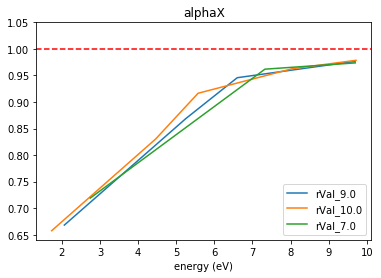

In [78]:
%matplotlib inline
component = 'alphaX'
for rVal in alpha_C6H6:
    val = np.array(alpha_C6H6[rVal][component])/C6H6_alpha_ref[component]
    plt.plot(alpha_C6H6[rVal]['naEnergy'],val,label='rVal_'+str(rVal))
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.title(component)
plt.ylim(ymax=1.05)
plt.show()

### Dynamical polarizability

In [79]:
reload(LR)
C6H6_spectrum = LR.collect_spectrum(C6H6)

Compute for rVal =  9.0  with nalpha =  169
numpoint =  227  omegaMax (eV) =  31.0166062508
Compute for rVal =  10.0  with nalpha =  220
numpoint =  228  omegaMax (eV) =  31.0830728297
Compute for rVal =  7.0  with nalpha =  94
numpoint =  228  omegaMax (eV) =  31.09085985


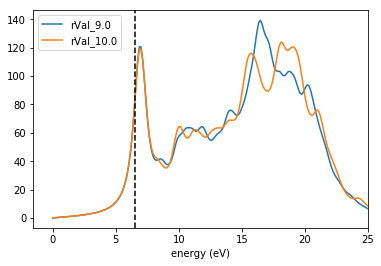

In [83]:
%matplotlib inline
syst = C6H6_spectrum
for rVal in [9.0,10.0]:#syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=25)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
#plt.title('Absorption spectrum')
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[7.0]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

### Excitations

We add the threshold key to the dictionary (for the first numExc excitations)

In [84]:
reload(LR)
numExc = 1000 #2000
LR.collect_excitation_thr(C6H6,norbC6H6,numExc,tol=1e-1)

In [86]:
for rVal in C6H6:
    nalpha = C6H6[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]
    maxEng = HaeV*np.sqrt(C6H6[rVal]['eigenproblems'][nvirt]['eigenvalues'][numExc-1]) 
    print 'maxEng for rval_', rVal, ' = ', maxEng

maxEng for rval_ 9.0  =  13.5074761597
maxEng for rval_ 10.0  =  12.8450322156
maxEng for rval_ 7.0  =  15.4923605166


We plot the excitations landscape in the different box

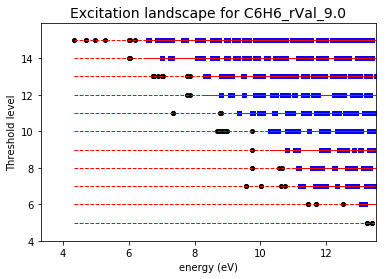

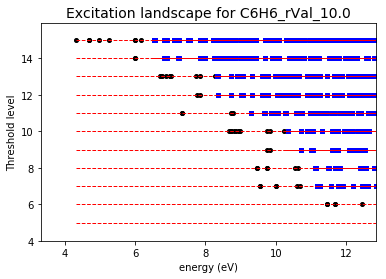

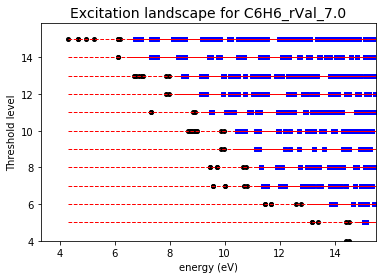

In [87]:
for rVal in C6H6:
    nalpha = C6H6[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]
    syst = C6H6[rVal]['eigenproblems'][nvirt]
    pEng = LR.get_p_energy(C6H6[rVal]['logfile'],norbC6H6)

    Emin = HaeV*np.sqrt(syst['eigenvalues'][0])
    Emax = HaeV*np.sqrt(syst['eigenvalues'][numExc-1])

    for ind,p in enumerate(pEng):
        plt.plot((Emin,HaeV*abs(p)),(ind+1,ind+1),'--',c='red',linewidth=1)
        plt.plot((HaeV*abs(p),Emax),(ind+1,ind+1),'-',c='red',linewidth=1)
    
    for exc in range(numExc):
        eng = HaeV*np.sqrt(syst['eigenvalues'][exc])
        thind = syst['thresholds'][exc][0]
        th = HaeV*syst['thresholds'][exc][1]
        if eng < th : 
            plt.scatter(eng,thind,s=16,marker='o',c='black')
        else :
            plt.scatter(eng,thind,s=14,marker='s',c='blue')
    plt.title('Excitation landscape for C6H6_rVal_'+str(rVal),size=14) 
    plt.xlabel('energy (eV)')
    plt.ylabel('Threshold level')
    plt.ylim(ymin=4)
    plt.xlim(xmin=Emin-1,xmax=Emax)
    plt.show()

We plot the dos (of a given channel) comparing the results of different box

In [88]:
reload(LR)
channels = LR.collect_channels(C6H6,norbC6H6,numExc)

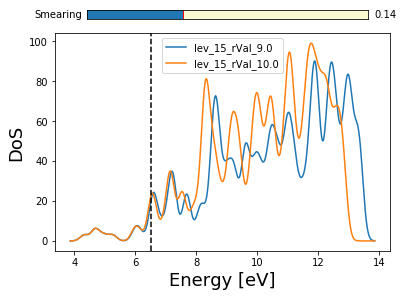

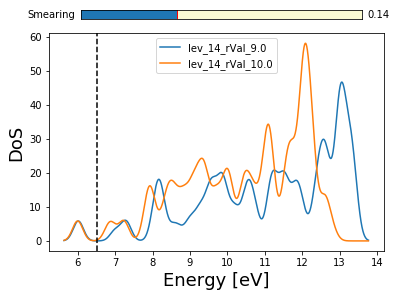

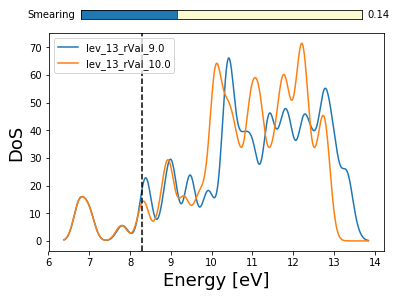

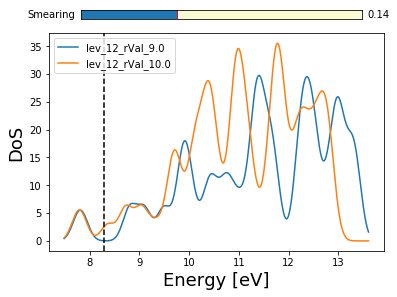

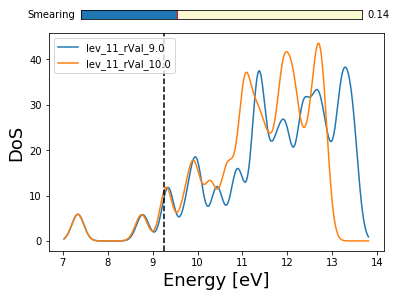

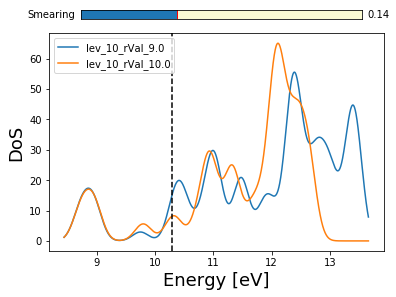

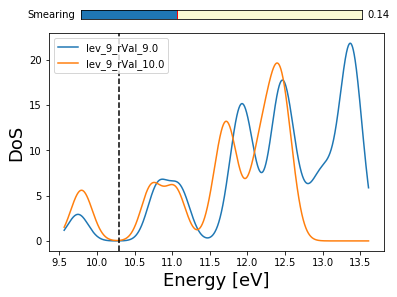

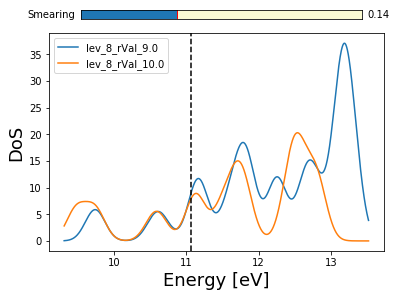

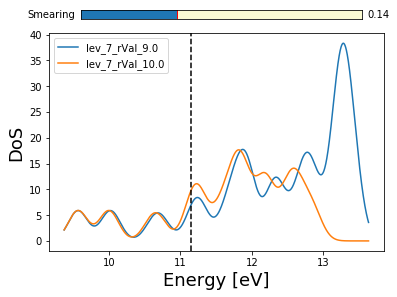

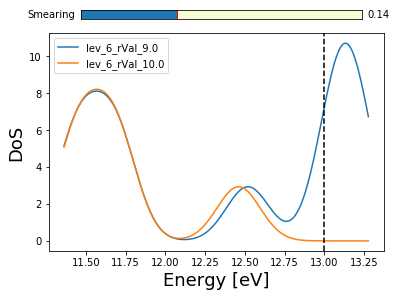

In [96]:
%matplotlib inline
levels = [15,14,13,12,11,10,9,8,7,6]
for l in levels:
    fe = HaeV*abs(LR.get_p_energy(C6H6[7.0]['logfile'],norbC6H6)[l-1])
    dos=D.DoS(fermi_level=fe)
    for rVal in [9.0,10.0]: #channels:
        dos.append(energies=np.array([channels[rVal][l-1]]),label='lev_'+str(l)+'_rVal_'+str(rVal))
    dos.plot(sigma=0.005*HaeV)

As a final analysis we repeat the calculation of dynamical polarizability separing the contributions due to excitations above and below threshold 

In [92]:
reload(LR)
C6H6_spectrum_bt,C6H6_spectrum_at = LR.collect_spectrum_bt_at(C6H6)

numpoint =  99  omegaMax (eV) =  13.5074761597
numpoint =  99  omegaMax (eV) =  13.5074761597
numpoint =  94  omegaMax (eV) =  12.8450322156
numpoint =  94  omegaMax (eV) =  12.8450322156
numpoint =  113  omegaMax (eV) =  15.4923605166
numpoint =  113  omegaMax (eV) =  15.4923605166


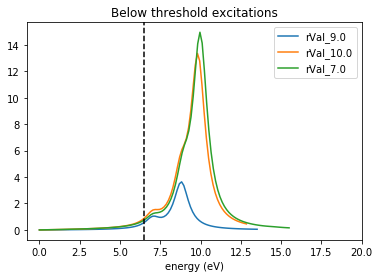

In [93]:
syst = C6H6_spectrum_bt
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=20)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Below threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[7.0]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

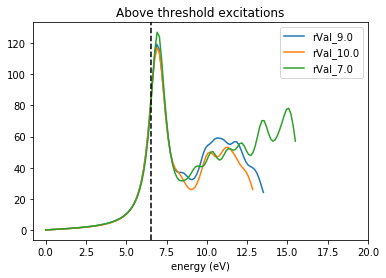

In [94]:
%matplotlib inline
syst = C6H6_spectrum_at
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=20)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Above threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[7.0]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

In [95]:
rVal= 7.0
syst = C6H6[rVal]['eigenproblems']
nalpha = syst.keys()
nalpha.sort()
nvirt = nalpha[-1]

for exc in range(50):

    pProj = LR.identify_contributions(norbC6H6,nvirt,exc,syst[nvirt]['eigenvectors'])
    out = pProj[0:norbC6H6] + pProj[norbC6H6:2*norbC6H6]
    for ind,o in enumerate(out):
        if o<1e-2: 
            out[ind] = 0.0
    som = 0
    for o in out: som+=o
    print out, som, HaeV*np.sqrt(syst[nvirt]['eigenvalues'][exc]),syst[nvirt]['oscillator_strength_avg'][exc] 

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.49712525  0.49740396] 0.99452920596 4.32413319159 6.73104214945e-32
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.49964347  0.49989431] 0.999537778037 4.68670603141 1.863713873e-30
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.49944749  0.50008986] 0.999537351821 4.68672468612 8.7740499286e-31
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.50054022  0.49936975] 0.999909965671 4.9653974086 3.98111204512e-31
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0

In [ ]:
def extractEigenProblems(box,np_small):
    """
    Build the dictionary with the solutions of the eigenproblems for each choice of na
    We perform the transpose of the matrix with eigenvectors to have them sorted as row vectors
    """
    return partial_eigenp([np_small],[box['nvirt']],box['C'],box['T'],[box['nvirt']])